# Importing necessary modules

In [5]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import random

from sklearn.utils import shuffle
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import Imputer, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, fbeta_score, make_scorer, accuracy_score
from sklearn.cross_validation import cross_val_score
from six.moves import cPickle as pickle


/home/apurvnit/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/apurvnit/anaconda3/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
def load_image(folder):
    valid_images = [".jpg", ".gif", ".png", ".tga"]
    all_char = os.listdir(folder)
    imgs_data = []
    Y = []
    
    for current_char in all_char:
        char_dir = os.path.join(folder,current_char)
        
        for image_name in os.listdir(char_dir):
            image_dir = os.path.join(char_dir, image_name)
            ext = os.path.splitext(image_dir)[1]
            
            if ext.lower() not in valid_images:
                continue
                
            try:
                img = Image.open(image_dir)
                img = np.array(img.resize((28,28),Image.ANTIALIAS))
                img = img.reshape(28*28)/255
                imgs_data.append(img)
                Y.append(current_char)
                
            except:
                print("unable to fetch image")
            
    print(np.array(imgs_data).shape, np.array(Y).reshape(len(Y),1).shape)
    return np.array(imgs_data,dtype=np.float32).T, np.array(Y).reshape(1,len(Y))

In [3]:
X, Y = load_image("/home/apurvnit/datasets/not_mnist/notMNIST_large")

unable to fetch image
unable to fetch image
unable to fetch image
unable to fetch image
unable to fetch image
(529114, 784) (529114, 1)


In [5]:
print("mean =",np.mean(X))
print("standard deviation = ",np.std(X))

mean = 0.418343
standard deviation =  0.454233


# Normalization - 
Making dataset of approx. zero mean and 1 variance

In [6]:
def randomize(X_var, Y_var):
    X, Y = shuffle(X_var.T, Y_var.T, random_state=random.randint(0,9))
    print(X.T.shape,Y.T.shape)
    return X.T, Y.T

In [7]:
X_1, Y_1 = randomize(X, Y)
print(X_1, Y_1)

(784, 529114) (1, 529114)
[[ 0.14509805  0.17647059  0.32549021 ...,  1.          0.          0.        ]
 [ 0.57254905  0.73333335  0.4509804  ...,  1.          0.          0.        ]
 [ 0.65882355  0.80392158  0.7019608  ...,  1.          0.          0.        ]
 ..., 
 [ 0.          0.          0.92941177 ...,  1.          0.          0.        ]
 [ 0.          0.          0.81176472 ...,  1.          0.          0.        ]
 [ 0.          0.          0.75294119 ...,  1.          0.          0.        ]] [['D' 'A' 'I' ..., 'A' 'F' 'G']]


In [8]:
def data_preprocessing(X, Y):
    
    Y_1 = LabelEncoder().fit_transform(Y.T)
    Y_1 = Y_1.reshape(1, Y.shape[1])
    onehot = OneHotEncoder(categorical_features = [1])
    Y = onehot.fit_transform(Y_1) 
    X_1, Y_1 = randomize(X,Y)
    X_train = X_1[:, 0:int(0.75*X_1.shape[1])]
    Y_train = Y_1[:, 0:int(0.75 * Y_1.shape[1])]
    X_test = X_1[:, int(0.75 * X_1.shape[1]):]
    Y_test = Y_1[:, int(0.75 * X_1.shape[1]):]
    
    
    return X_train,Y_train,X_test,Y_test
    

In [10]:
X_train,Y_train,X_test,Y_test = data_preprocessing(X, Y)

/home/apurvnit/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(784, 529114) (1, 529114)


Since we have made and classified data for our program. lets save it so that we dont have to do such a long work again and again

In [11]:
def save_dataset(pickle_file):

    try:
      f = open(pickle_file, 'wb')
      save = {
        'train_dataset': X_train,
        'train_labels': Y_train,
        'test_dataset': X_test,
        'test_labels': Y_test,
        }
      pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
      f.close()
    except Exception as e:
      print('Unable to save data to', pickle_file, ':', e)
      raise

In [12]:
pickle_file = os.path.join("/home/apurvnit/Projects/My_deep-learning_examples/char_recognition", 'char_recognition.pickle')
save_dataset(pickle_file)
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 1667133176


# Second part of the model

Since we have already preprocessed the data it would be better to directly call the variables from pickle file created before


In [6]:
pickle_file = "../../pickle_files/char_recognition.pickle"

with open(pickle_file,'rb') as file:
    s = pickle.load(file)
    X_train_1 = s['train_dataset']
    Y_train_1 = s['train_labels']
    X_test_1 = s['test_dataset']
    Y_test_1 = s['test_labels']
    

Restructuring variables

In [7]:
print(Y_test_1.shape, X_test_1.shape)
Y = Y_train_1.toarray()
Y_train_2 = Y.reshape(Y.shape[-1])
Y = Y_test_1.toarray()
Y_test_2 = Y.reshape(Y.shape[-1])
Y_train = (np.arange(10) == Y_train_2[:,None]).astype(np.float32)
Y_test_3 = (np.arange(10) == Y_test_2[:,None]).astype(np.float32)
print(Y_train.shape)

(1, 132279) (784, 132279)
(396835, 10)


In [8]:
valid_size = int(5 * Y_test_3.shape[0]/10)
print(valid_size)
Y_test = Y_test_3[:valid_size]
print(Y_test_3.shape)
Y_valid = Y_test_3[valid_size:]
X_test = X_test_1.T[:valid_size]
X_valid = X_test_1.T[valid_size:]
print(X_valid.shape, X_test.shape)
print(X_train_1.shape)

66139
(132279, 10)
(66140, 784) (66139, 784)
(784, 396835)


In [9]:
# Importing tenserflow modules
import tensorflow as tf

To start writing code in tenserflow , you need to assign variables and constants and kind of attach it to tenserflow.
Then, You can create a session and run these operations as many times as you want.


In [10]:
# simple gradient descent
subset = 20000
num_labels = 10
graph = tf.Graph()
with graph.as_default():
    tf_X = tf.constant(X_train_1.T[:subset])
    tf_Y = tf.constant(Y_train[:subset])
    tf_test_X = tf.constant(X_test)
    tf_val_X = tf.constant(X_valid)

    # Variables.
    # These are the parameters that we are going to be training. The weight
    # matrix will be initialized using random values following a (truncated)
    # normal distribution. The biases get initialized to zero.
    tf_w = tf.Variable(tf.truncated_normal([28*28,num_labels]))
    tf_b = tf.Variable(tf.zeros([num_labels]))

    # Computing training values with softmax cross entropy and logits
    logits = tf.matmul(tf_X, tf_w) + tf_b
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_Y, logits=logits))

    # now using gradient descent finding minimal loss
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
    tf.matmul(tf_val_X, tf_w) + tf_b)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_X, tf_w) + tf_b)


In [11]:
num_steps = 800

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

with tf.Session(graph=graph) as sess:
    # simple stuff that happens in a forward and back prop
    tf.global_variables_initializer().run()
    for i in range(num_steps):
        # running the optimizer using .run()
        _, l, predictions = sess.run([optimizer, loss, train_prediction])
        
        if (i % 100 == 0):
            print('Loss at step %d: %f' % (i, l))
            print('Training accuracy: %.1f%%' % accuracy(
            predictions, Y_train[:subset, :]))
            print('Validation accuracy: %.1f%%' % accuracy(
            valid_prediction.eval(), Y_valid))
            
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), Y_test))



Loss at step 0: 23.717478
Training accuracy: 5.4%
Validation accuracy: 8.6%
Loss at step 100: 2.375427
Training accuracy: 71.7%
Validation accuracy: 71.4%
Loss at step 200: 1.957463
Training accuracy: 74.4%
Validation accuracy: 73.9%
Loss at step 300: 1.728888
Training accuracy: 75.6%
Validation accuracy: 74.9%
Loss at step 400: 1.574508
Training accuracy: 76.1%
Validation accuracy: 75.3%
Loss at step 500: 1.460055
Training accuracy: 76.7%
Validation accuracy: 75.6%
Loss at step 600: 1.379029
Training accuracy: 77.1%
Validation accuracy: 75.6%
Loss at step 700: 1.340731
Training accuracy: 77.0%
Validation accuracy: 75.2%
Test accuracy: 74.4%


 Now using stochastic gradient descent with batch size as 128

In [12]:
batch_size = 128
graph = tf.Graph()
with graph.as_default():
    
  tf_X = tf.placeholder(tf.float32, shape=(batch_size, 28*28))
  tf_Y = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_val_X = tf.constant(X_valid)
  tf_test_X = tf.constant(X_test)
  
  # Variables.
  tf_w = tf.Variable(
    tf.truncated_normal([28 * 28, num_labels]))
  tf_b = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_X, tf_w) + tf_b
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_Y, logits=logits))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_val_X, tf_w) + tf_b)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_X, tf_w) + tf_b)

In [84]:
def process_learning():
    num_steps = 8801
    valid_loss = []
    valid_step = []

    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        for step in range(num_steps):

            # Pick an offset within the training data, which has been randomized.

            offset = (step * batch_size) % (Y_train.shape[0] - batch_size)

            # Generate a minibatch.
            batch_data = X_train_1.T[offset:(offset + batch_size)]
            batch_labels = Y_train[offset:(offset + batch_size), :]

            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_X : batch_data, tf_Y : batch_labels}
            _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (step % 500 == 0):
                valid_loss.append(l)
                valid_step.append(step)
                print("Minibatch loss at step %d: %f" % (step, l))
                print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
                print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), Y_valid))
        print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), Y_test))
    return valid_loss, valid_step

In [85]:
valid_loss, valid_step = process_learning()

Minibatch loss at step 0: 22.330101
Minibatch accuracy: 6.2%
Validation accuracy: 14.4%
Minibatch loss at step 500: 2.027299
Minibatch accuracy: 75.0%
Validation accuracy: 77.2%
Minibatch loss at step 1000: 1.213048
Minibatch accuracy: 81.2%
Validation accuracy: 77.9%
Minibatch loss at step 1500: 2.366912
Minibatch accuracy: 66.4%
Validation accuracy: 73.3%
Minibatch loss at step 2000: 2.323656
Minibatch accuracy: 71.9%
Validation accuracy: 76.4%
Minibatch loss at step 2500: 1.682052
Minibatch accuracy: 76.6%
Validation accuracy: 76.1%
Minibatch loss at step 3000: 1.352516
Minibatch accuracy: 76.6%
Validation accuracy: 79.4%
Minibatch loss at step 3500: 1.210317
Minibatch accuracy: 76.6%
Validation accuracy: 76.7%
Minibatch loss at step 4000: 1.047042
Minibatch accuracy: 83.6%
Validation accuracy: 81.0%
Minibatch loss at step 4500: 1.260114
Minibatch accuracy: 75.8%
Validation accuracy: 78.6%
Minibatch loss at step 5000: 1.140914
Minibatch accuracy: 75.8%
Validation accuracy: 76.6%
Min

# Finding optimal hyperparameters.

## 1- getting suitable batch_size and steps.

Plotting the improvement in predicting our SGD model's valid dataset

In [86]:
import matplotlib.pyplot as plt

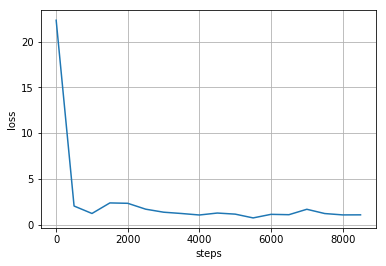

In [87]:
def plot_graph(valid_loss, valid_step):
    plt.xlabel("steps")
    plt.ylabel("loss")
    plt.plot(valid_step, valid_loss)
    plt.grid()
    plt.show()

plot_graph(valid_loss, valid_step)

## 2- using L2 Regularization

In [88]:
batch_size = 128
graph = tf.Graph()
with graph.as_default():
    
  tf_X = tf.placeholder(tf.float32, shape=(batch_size, 28*28))
  tf_Y = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_val_X = tf.constant(X_valid)
  tf_test_X = tf.constant(X_test)
  
  # Variables.
  tf_w = tf.Variable(
    tf.truncated_normal([28 * 28, num_labels]))
  tf_b = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_X, tf_w) + tf_b
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_Y, logits=logits)
  )+0.0001*tf.nn.l2_loss(tf_w)+0.0001*tf.nn.l2_loss(tf_b)
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_val_X, tf_w) + tf_b)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_X, tf_w) + tf_b)

Minibatch loss at step 0: 17.553072
Minibatch accuracy: 11.7%
Validation accuracy: 12.1%
Minibatch loss at step 500: 1.928773
Minibatch accuracy: 77.3%
Validation accuracy: 76.5%
Minibatch loss at step 1000: 1.464758
Minibatch accuracy: 75.8%
Validation accuracy: 73.3%
Minibatch loss at step 1500: 1.956424
Minibatch accuracy: 72.7%
Validation accuracy: 77.3%
Minibatch loss at step 2000: 1.778240
Minibatch accuracy: 71.9%
Validation accuracy: 74.6%
Minibatch loss at step 2500: 1.362198
Minibatch accuracy: 76.6%
Validation accuracy: 78.4%
Minibatch loss at step 3000: 1.304243
Minibatch accuracy: 77.3%
Validation accuracy: 77.7%
Minibatch loss at step 3500: 1.332424
Minibatch accuracy: 75.0%
Validation accuracy: 76.6%
Minibatch loss at step 4000: 1.185252
Minibatch accuracy: 85.2%
Validation accuracy: 80.2%
Minibatch loss at step 4500: 1.271850
Minibatch accuracy: 78.9%
Validation accuracy: 79.9%
Minibatch loss at step 5000: 1.014623
Minibatch accuracy: 75.8%
Validation accuracy: 76.3%
Mi

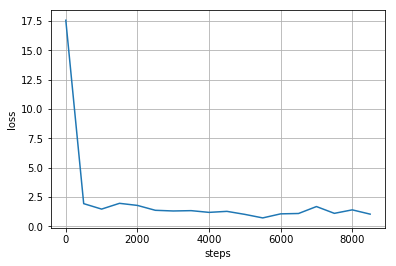

In [89]:
valid_loss, valid_step = process_learning()
plot_graph(valid_loss, valid_step)

## 3- Dropout Regularization

In [ ]:
batch_size = 128
graph = tf.Graph()
with graph.as_default():
    
  tf_X = tf.placeholder(tf.float32, shape=(batch_size, 28*28))
  tf_Y = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_val_X = tf.constant(X_valid)
  tf_test_X = tf.constant(X_test)
  
  # Variables.
  tf_w = tf.Variable(
    tf.truncated_normal([28 * 28, num_labels]))
  tf_b = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_X, tf_w) + tf_b
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_Y, logits=logits))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_val_X, tf_w) + tf_b)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_X, tf_w) + tf_b)

## 4- Using multilayered relu 

In [ ]:
batch_size = 128
graph = tf.Graph()
with graph.as_default():
    
  tf_X = tf.placeholder(tf.float32, shape=(batch_size, 28*28))
  tf_Y = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_val_X = tf.constant(X_valid)
  tf_test_X = tf.constant(X_test)
  
  # Variables.
  tf_w = tf.Variable(
    tf.truncated_normal([28 * 28, num_labels]))
  tf_b = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_X, tf_w) + tf_b
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_Y, logits=logits))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_val_X, tf_w) + tf_b)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_X, tf_w) + tf_b)